# Pipeline for the anomaly detection on the SKAB using MSET

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (665, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 13241

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 16:28:16,0.080968,0.132892,2.078540,0.054711,88.8333,22.0874,248.524,75.0000,0.0,0.0
2020-03-01 16:28:17,0.080721,0.137438,0.983799,0.710565,88.9111,22.0892,226.593,75.9813,0.0,0.0
2020-03-01 16:28:18,0.081400,0.128858,1.666630,0.054711,88.8676,22.0930,216.814,75.0000,0.0,0.0
2020-03-01 16:28:19,0.080755,0.135728,1.090530,0.382638,88.8907,22.0862,230.363,75.0189,0.0,0.0
2020-03-01 16:28:20,0.080394,0.132174,1.199950,0.382638,88.9437,22.0903,251.789,75.9813,0.0,0.0


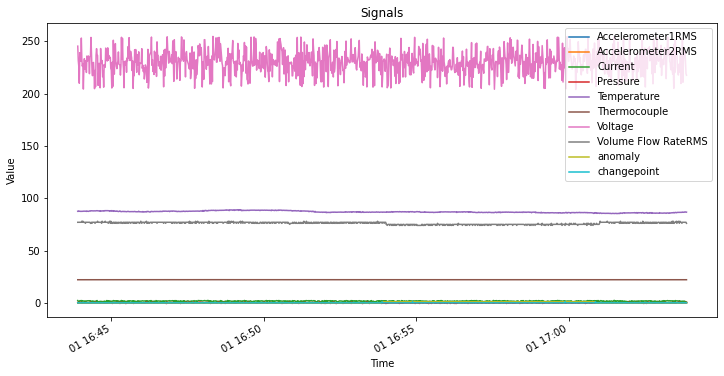

In [5]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

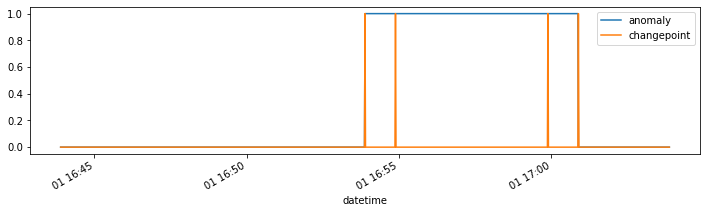

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12,3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [96]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import linalg as spla
import os, sys
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

Random(10)

### Training once in the beginning

In [78]:
def kernel(x,y):

    '''
    s(x,y) = 1 - ||x-y||/(||x|| + ||y||)
    '''

    if all(x==y):
        # Handling the case of x and y both being the zero vector.
        return 1.
    else:
        return 1. - np.linalg.norm(x-y)/(np.linalg.norm(x) + np.linalg.norm(y))

def otimes(X, Y):

    m1,n = np.shape(X)
    m2,p = np.shape(Y)

    if m1!=m2:
        raise Exception('dimensionality mismatch between X and Y.')

    Z = np.zeros( (n,p) )

    if n != p:
        for i in range(n):
            for j in range(p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
    else:
        for i in range(n):     
            for j in range(i, p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
                Z[j,i] = Z[i,j]

    return Z

def movmean(array, window):

    n = np.size(array)
    xx = array.copy()
    y = []
    for i in range(0, window):
        y.append(np.roll(xx.tolist() + [np.nan]*window, i))
    y = np.nanmean(y, axis=0)
    l = math.ceil(window/2)

    return y[l-1:n+l-1]

class MSET:
        
    def __init__(self):
        pass
    
    def calc_W(self, X_obs):
        
        DxX_obs = otimes(self.D, X_obs)
        try:
            W = spla.lu_solve(self.LU_factors, DxX_obs)
        except:
            W = np.linalg.solve(self.DxD, DxX_obs)
    
        return W

    def fit(self, df, train_start = None, train_stop = None):
        
        self.D = df[train_start:train_stop].values.T.copy() # memory matrix
        self.SS = StandardScaler()
        self.D = self.SS.fit_transform(self.D.T).T
        
        self.DxD = otimes(self.D, self.D)
        self.LU_factors = spla.lu_factor(self.DxD)
        
    def predict(self, df):
        
        X_obs = df.values.T.copy() 
        X_obs = self.SS.transform(X_obs.T).T
#         pred = pd.DataFrame(index=df.index, columns=df.columns)
        pred = np.zeros(X_obs.T.shape)
        
        for i in range(X_obs.shape[1]):
            pred[[i],:] = (self.D @ self.calc_W(X_obs[:,i].reshape([-1,1]))).T
            
        return pd.DataFrame(self.SS.inverse_transform(pred), index=df.index, columns=df.columns)

In [112]:
df = list_of_df[1]
df = df.drop(['anomaly','changepoint'], axis=1)

In [113]:
%%time
ms = MSET()
ms.fit(df[:400])

Wall time: 1.57 s


In [114]:
%%time
Y_pred = ms.predict(df)

Wall time: 8.96 s


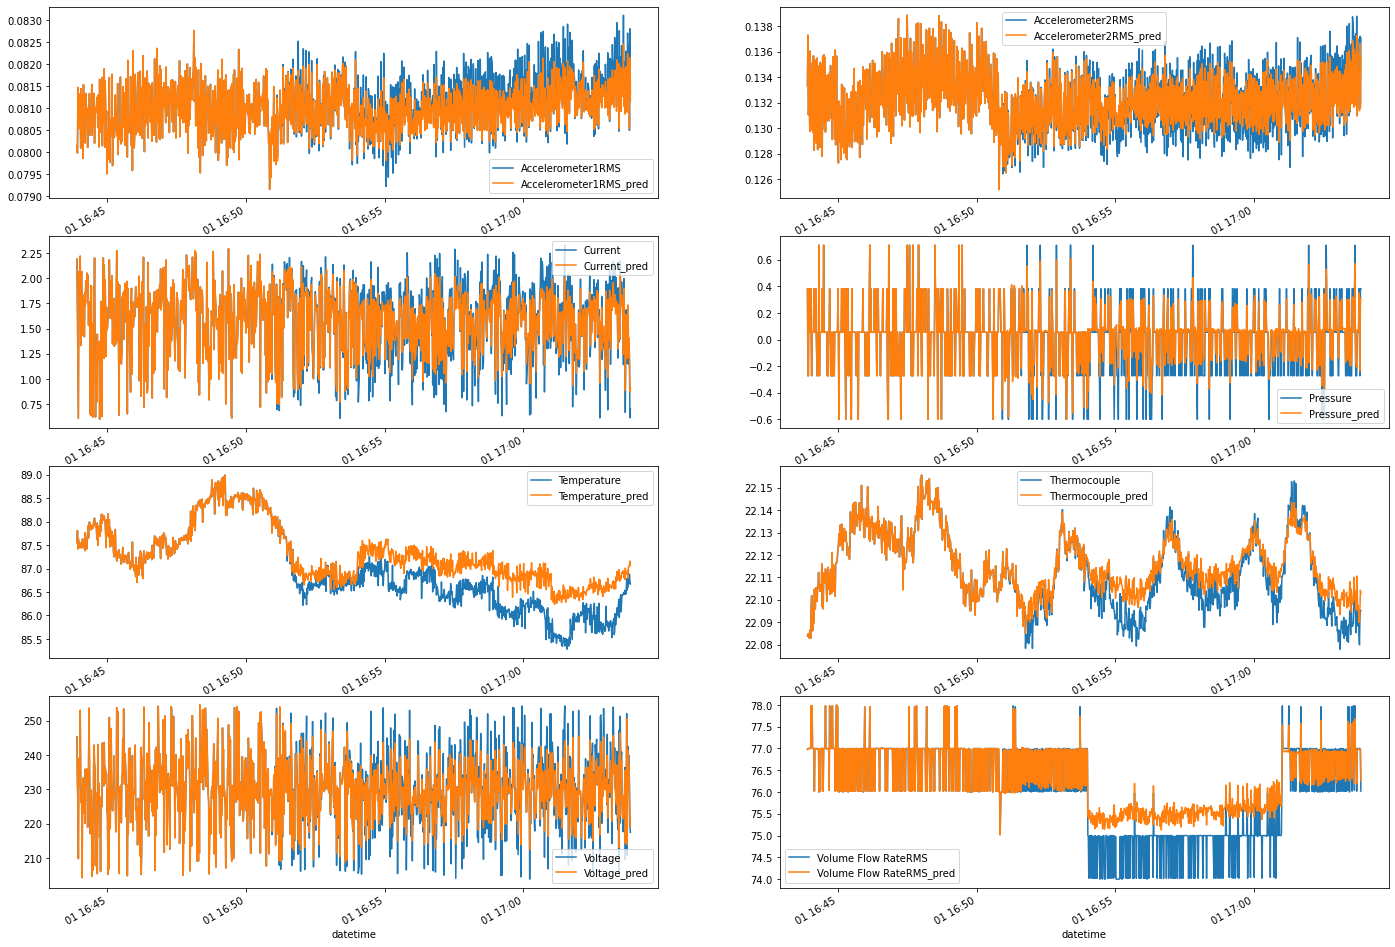

In [115]:
fig, axes = plt.subplots(df.shape[1]//2, 2, figsize=(24,18))
for i, col in enumerate(df.columns):
    ax = axes.flatten()[int(i)]
    df[col].plot(ax=ax)
    Y_pred[col].plot(ax=ax, label=f'{col}_pred')
    ax.legend()

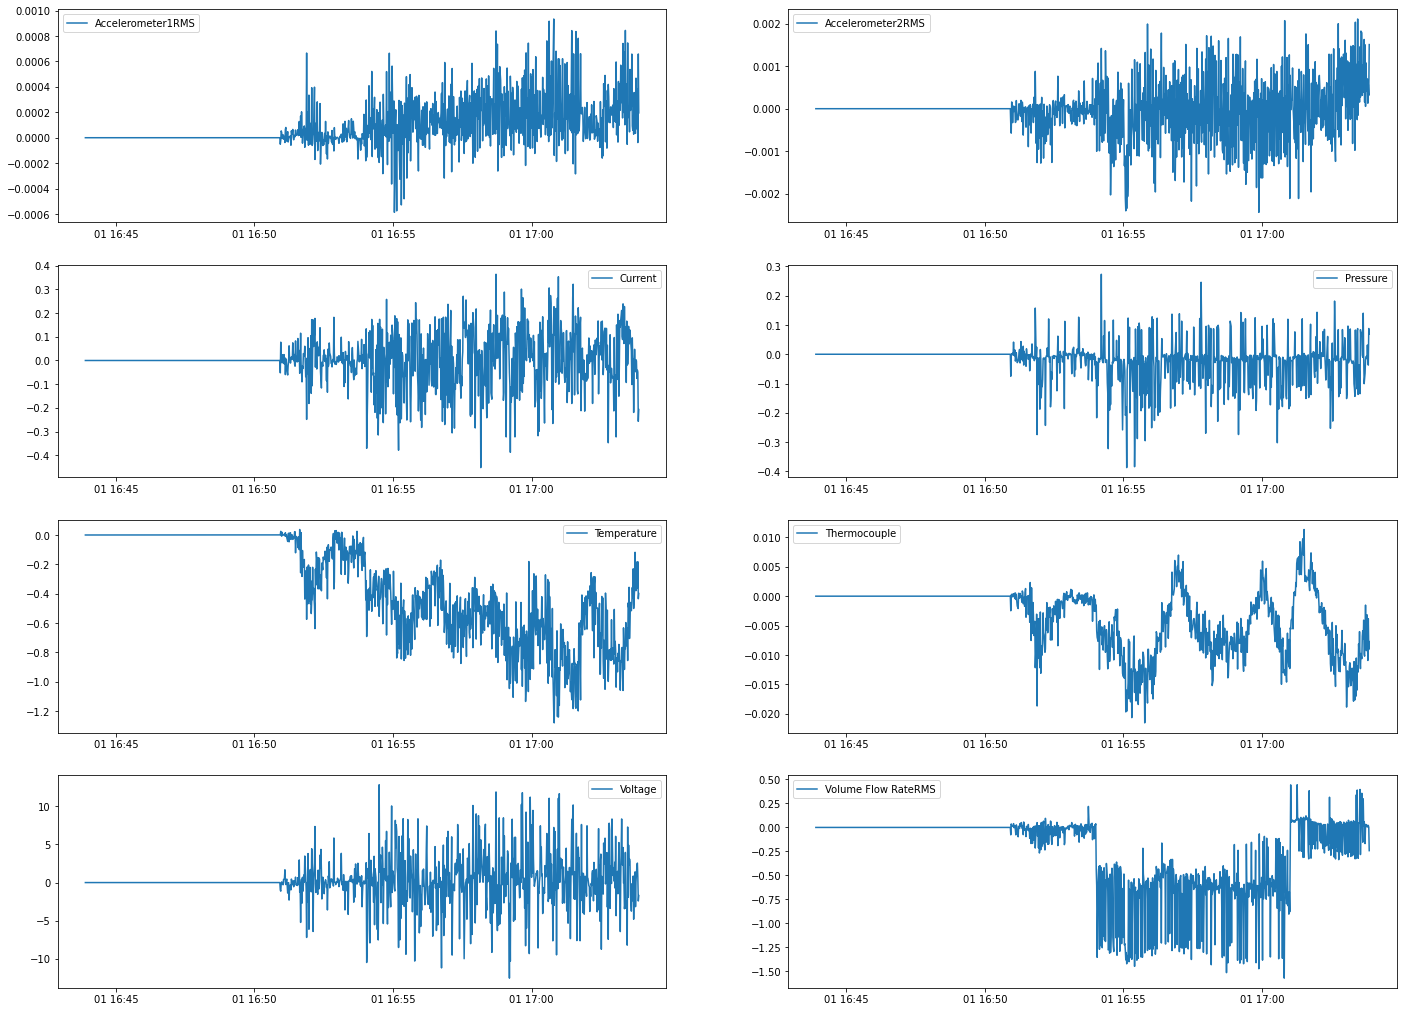

In [116]:
fig, axes = plt.subplots(df.shape[1]//2, 2, figsize=(24,18))
for i, col in enumerate(df.columns):
    ax = axes.flatten()[int(i)]
    ax.plot(df.index, (df - Y_pred)[col], label=col)
    ax.legend()

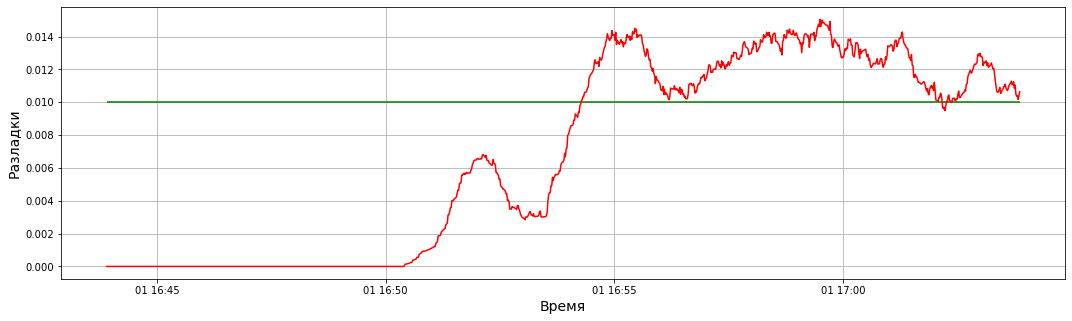

In [117]:
err = np.linalg.norm((df - Y_pred), axis=1)
rel_err = movmean(err/np.linalg.norm(Y_pred, axis=1), 
                  window=60)
UCL = 0.01
plt.figure(figsize=(18,5))
plt.plot(df.index, rel_err, c='r')
plt.hlines(UCL, df.index[0], df.index[-1], 'g')
plt.grid()
plt.xlabel('Время', fontsize=14)
plt.ylabel('Разладки', fontsize=14);

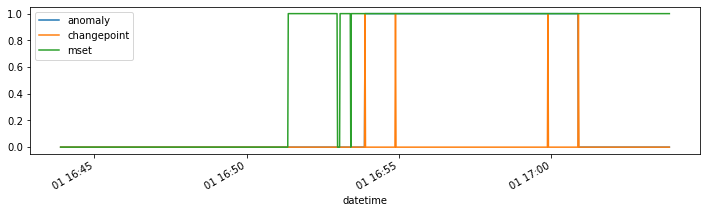

In [118]:
# plotting the labels both for outlier and changepoint detection problems
prediction = pd.DataFrame((rel_err>0.003),
                          df.index).fillna(0).any(axis=1).astype(int)
list_of_df[1].anomaly.plot(figsize=(12,3))
list_of_df[1].changepoint.plot()
# plt.plot(t, r, label = 'mscred')
plt.plot(df.index, prediction, label = 'mset')
plt.legend()
plt.show()

### Training in the beginning of each dataset

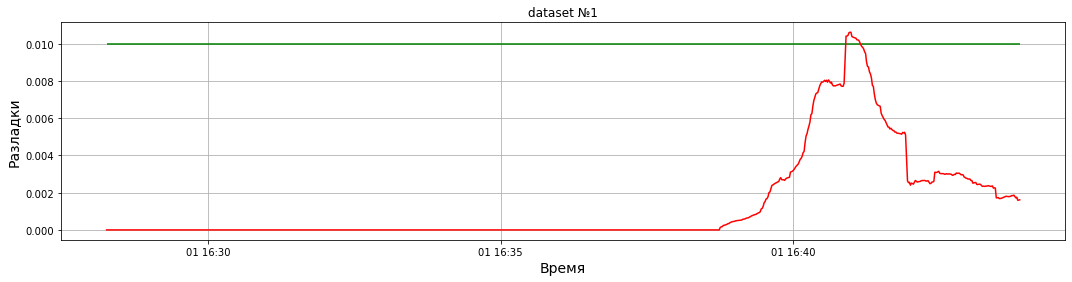

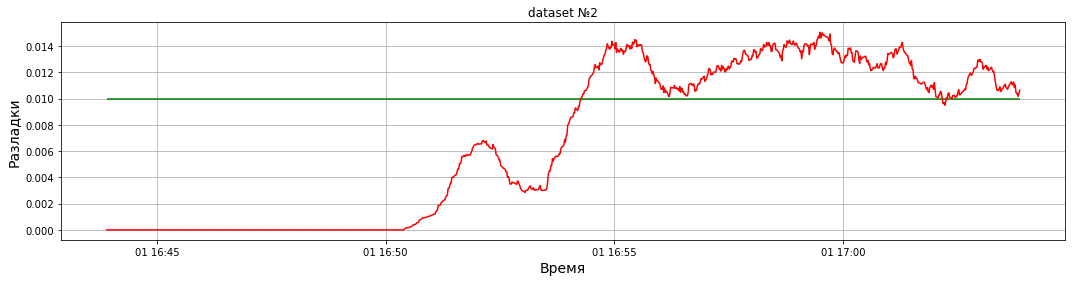

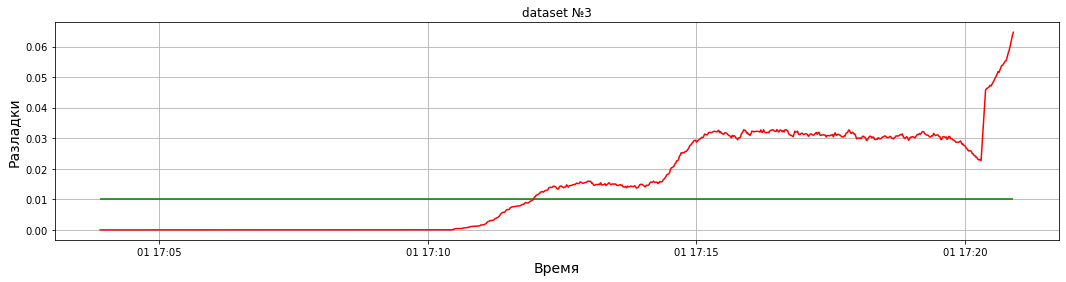

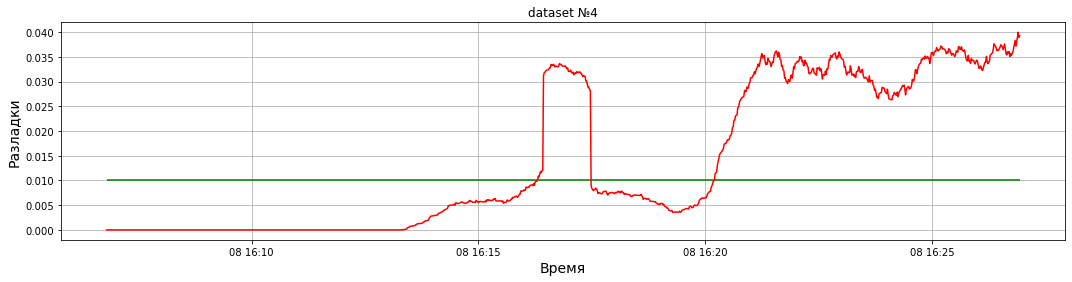

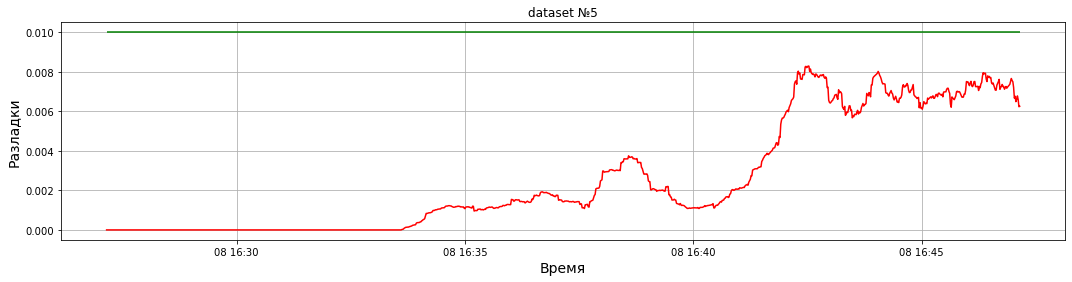

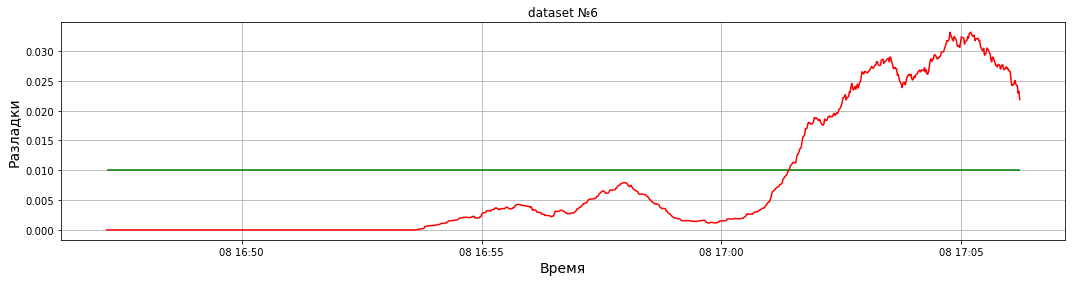

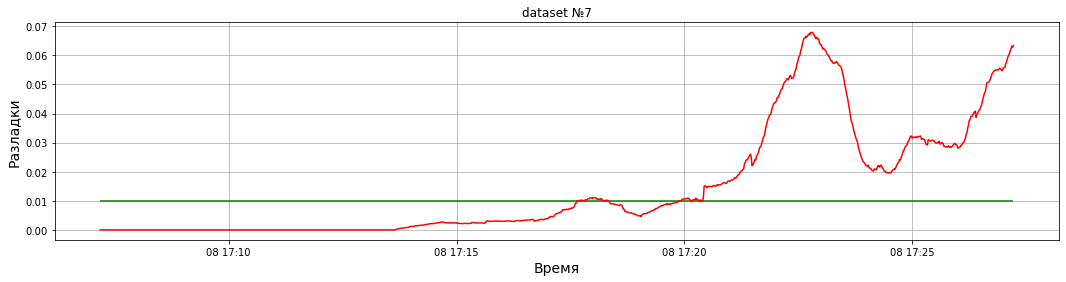

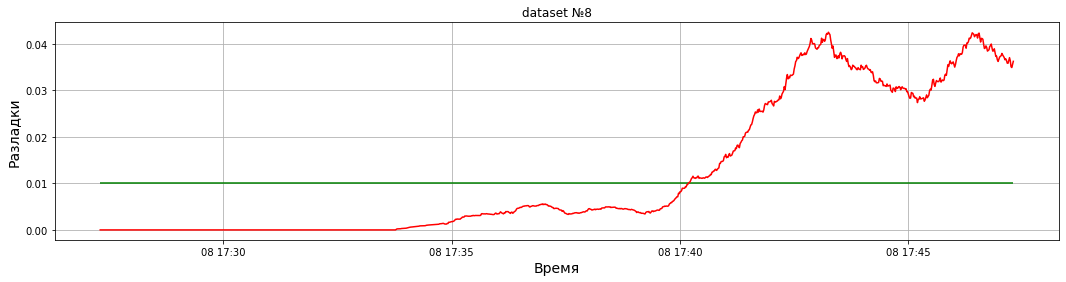

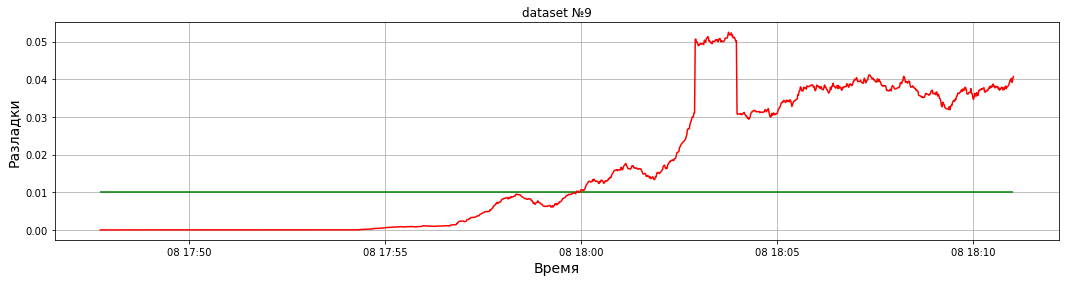

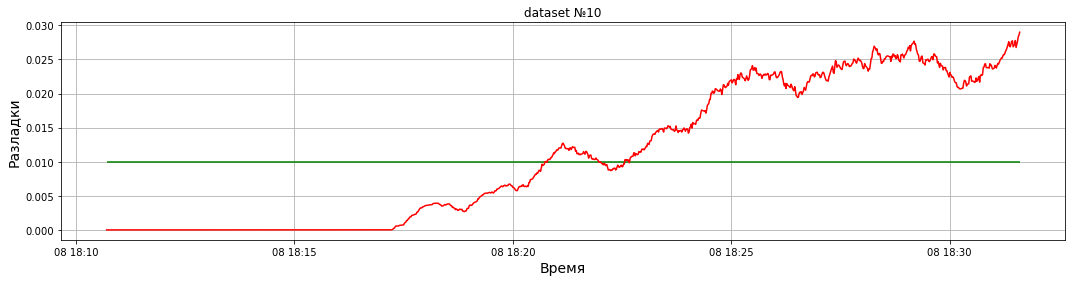

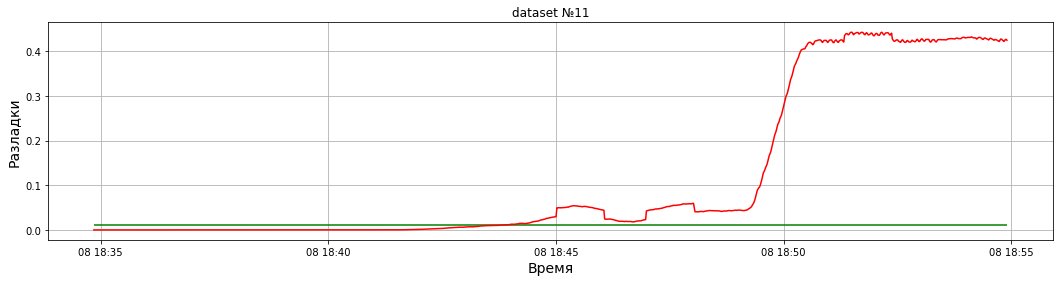

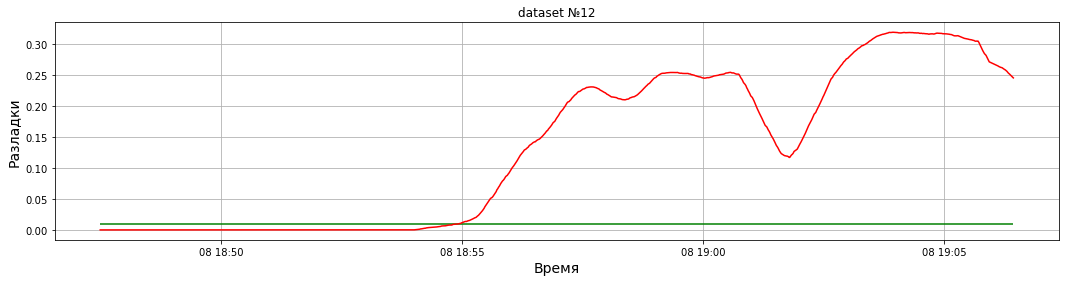

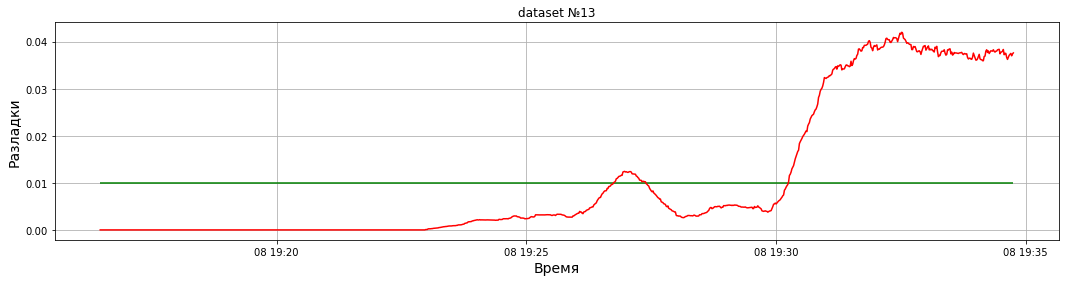

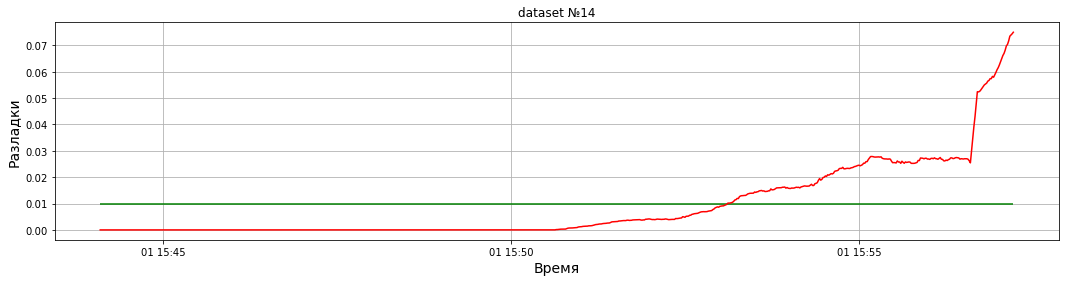

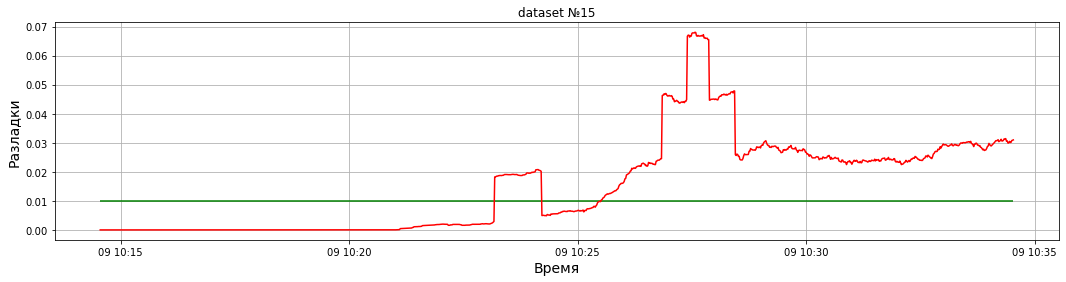

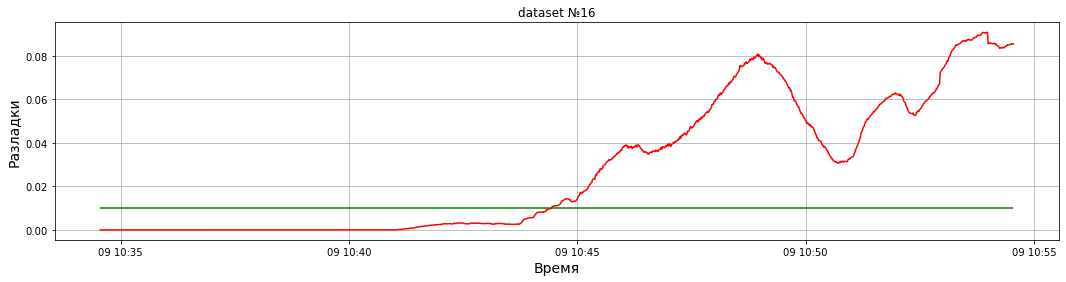

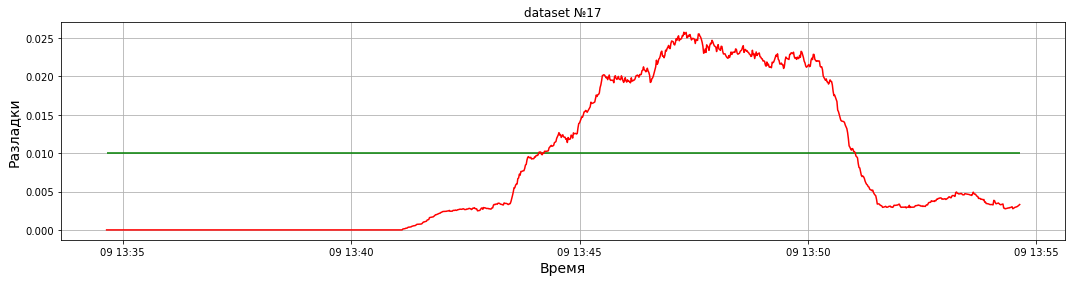

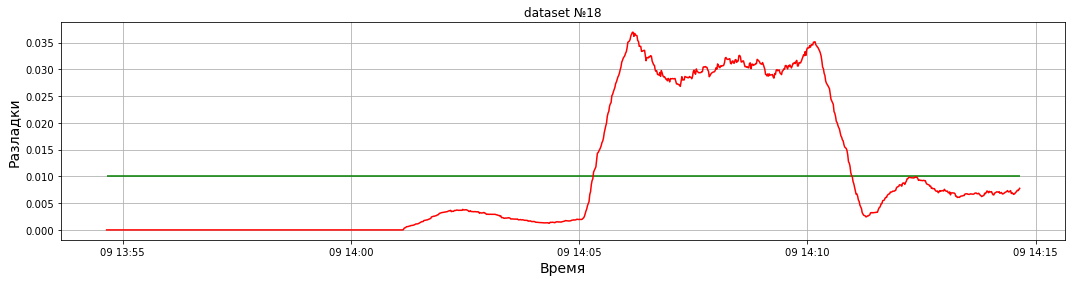

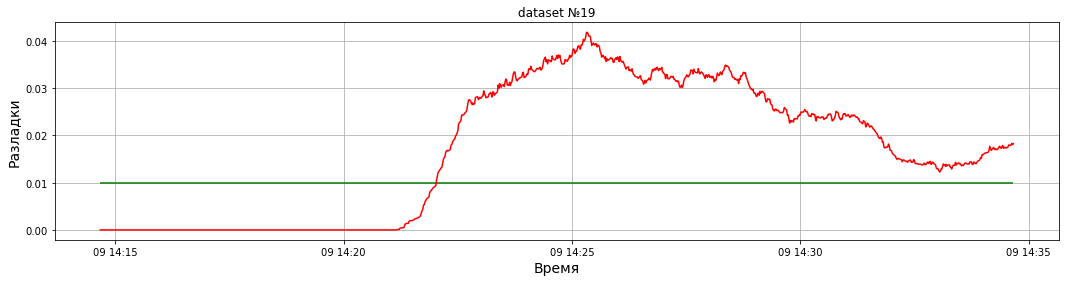

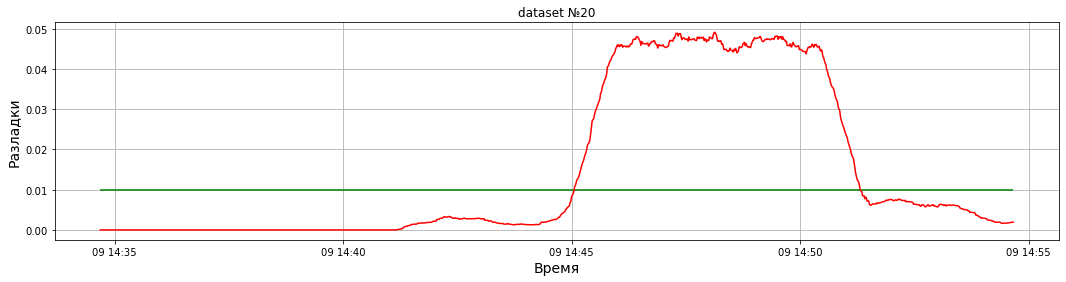

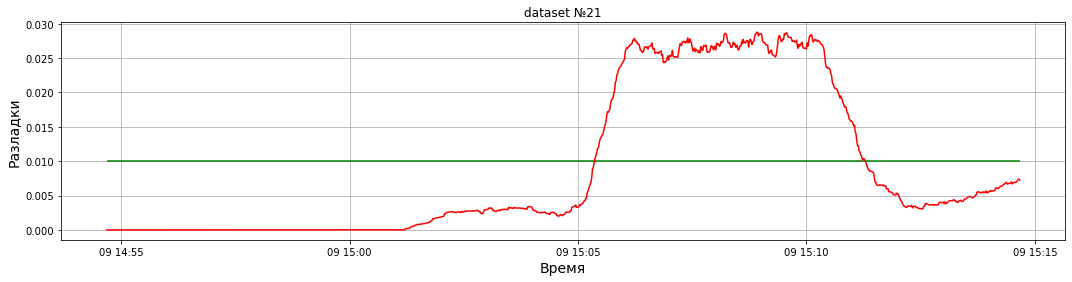

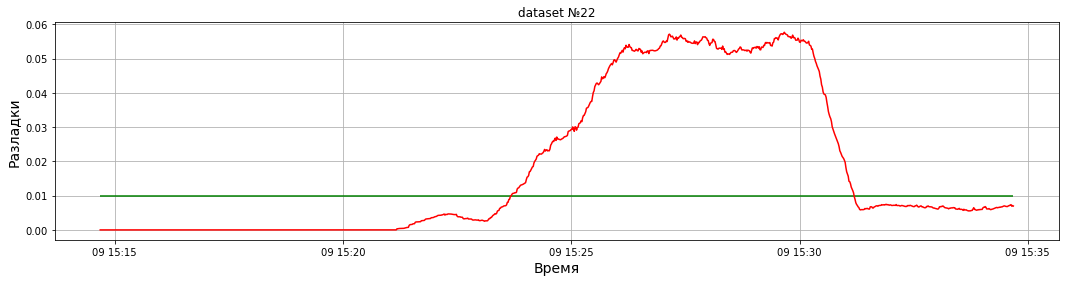

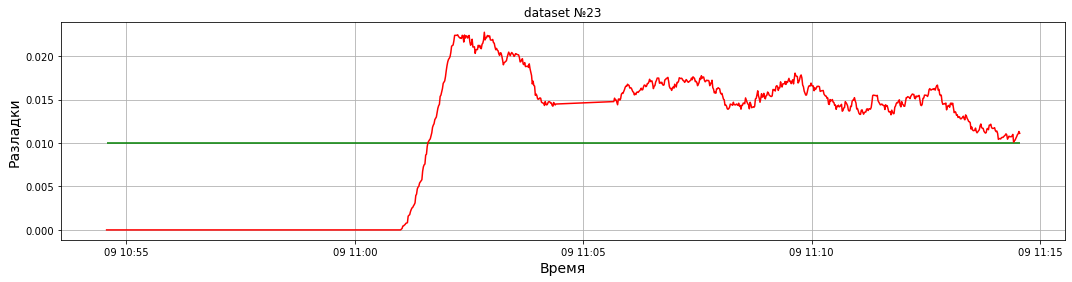

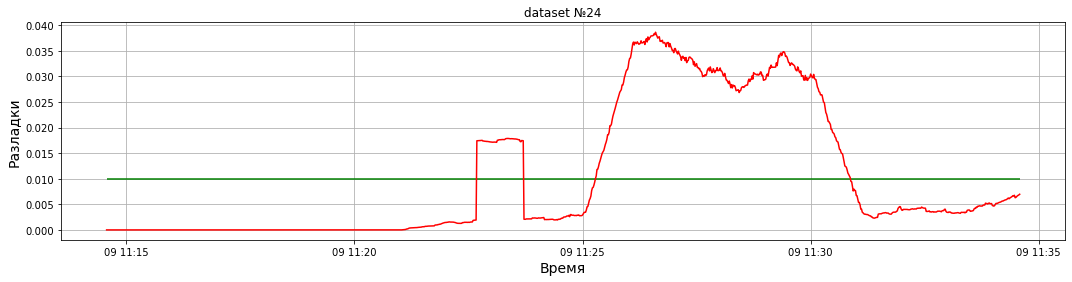

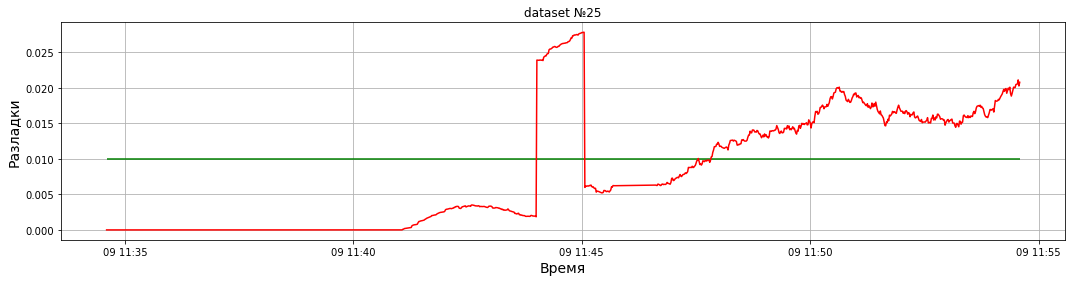

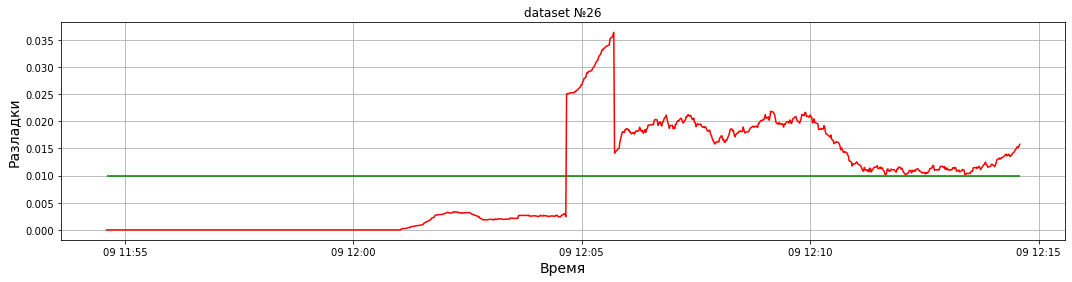

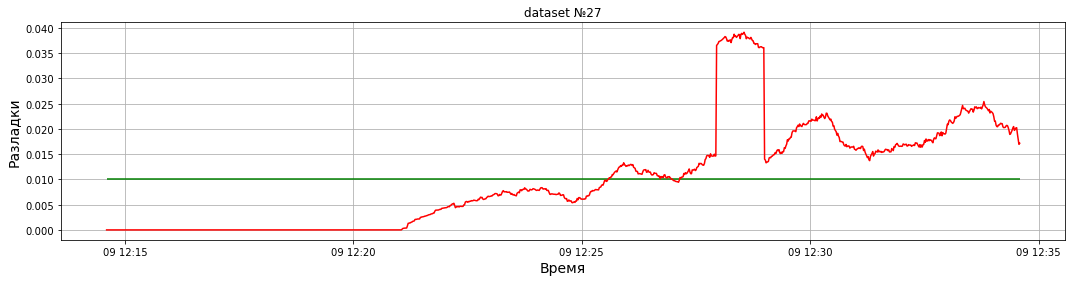

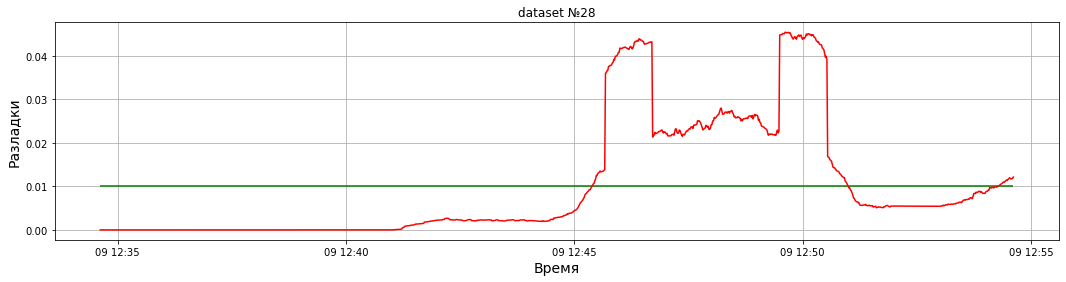

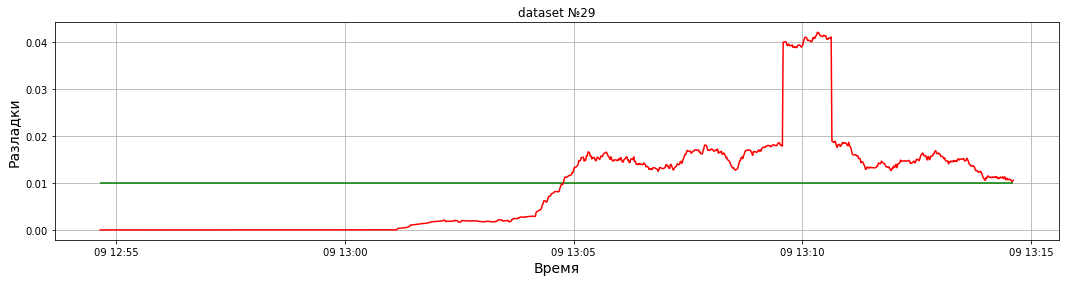

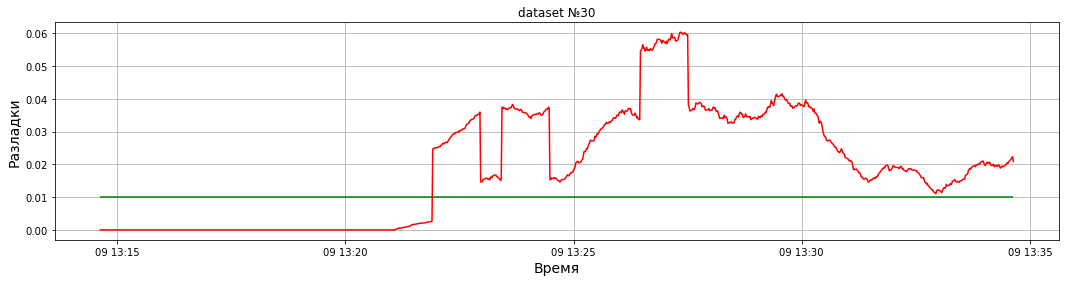

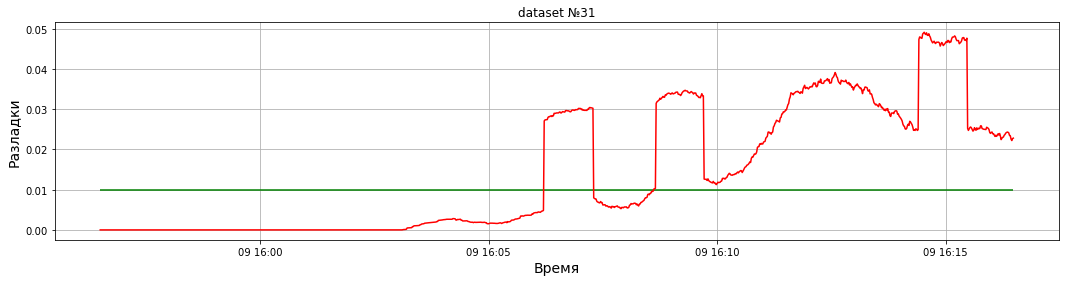

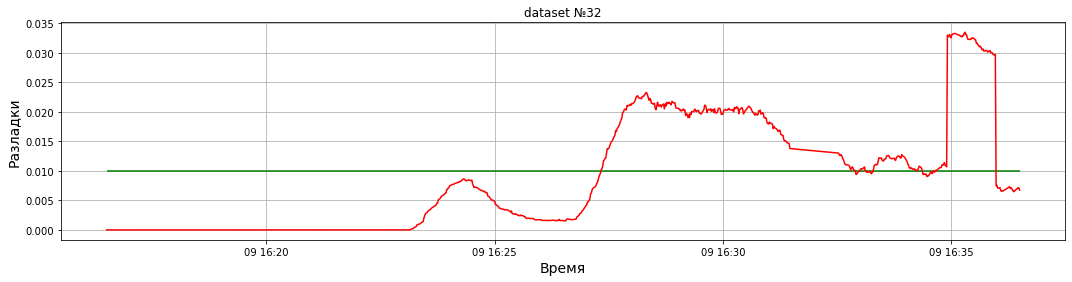

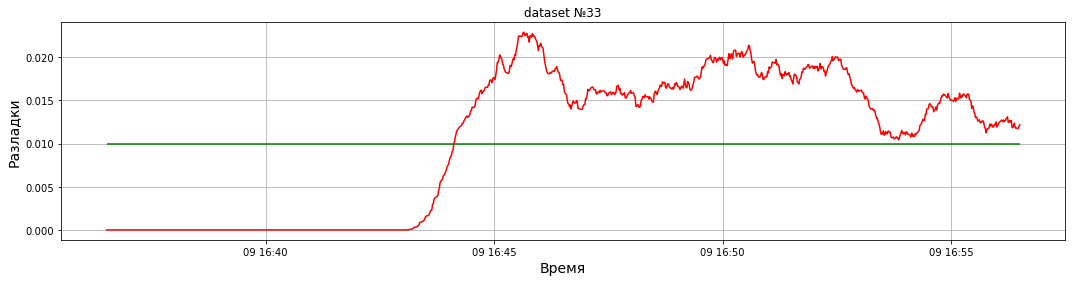

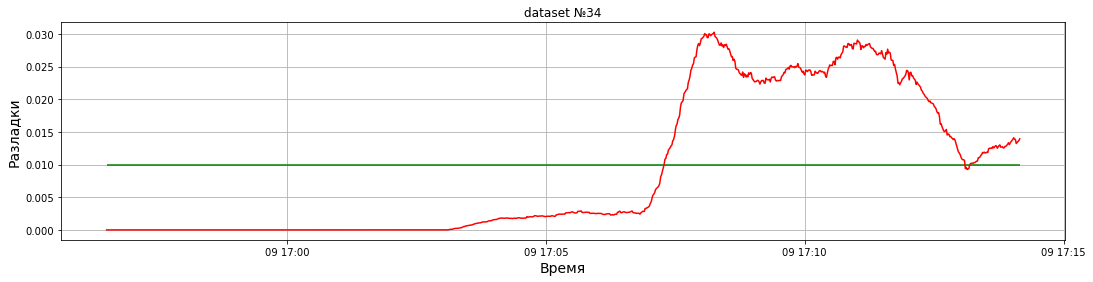

Wall time: 5min 44s


In [106]:
%%time

# inference
predicted_outlier, predicted_cp = [], []
rel_errors = []
x = 0 
for df in list_of_df:
    
    x += 1
#     print(f'dataset №{x}')
    df = df.drop(['anomaly','changepoint'], axis=1)
    train_stop = 400
    
    ms = MSET()
    ms.fit(df[:train_stop])
    
    # results predicting
    Y_pred = ms.predict(df)
    err = np.linalg.norm(df - Y_pred, axis=1)
    rel_err = movmean(err/np.linalg.norm(Y_pred, axis=1), 
                      window=60)
    rel_errors.append(rel_err)
    
    UCL = 0.01
    prediction = pd.DataFrame((rel_err>UCL),
                               df.index).fillna(0).any(axis=1).astype(int)
    
    # plot 
    plt.figure(figsize=(18,4))
    plt.title(f'dataset №{x}')
    plt.plot(df.index, rel_err, c='r')
    plt.hlines(UCL, df.index[0], df.index[-1], 'g')
    plt.grid()
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Разладки', fontsize=14)
    plt.show()
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results

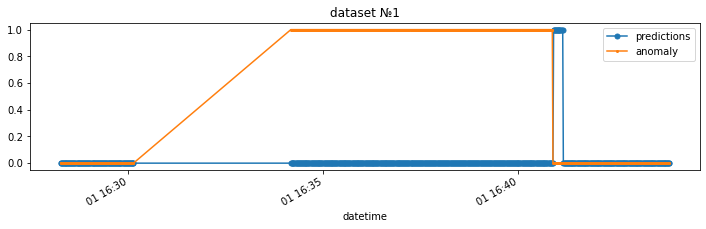

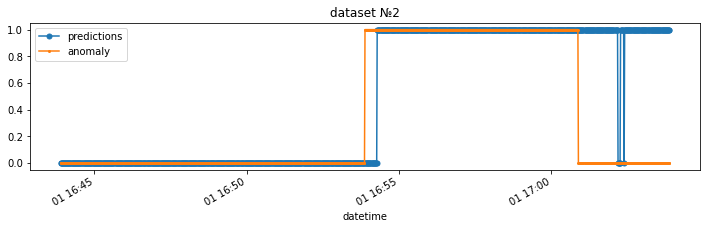

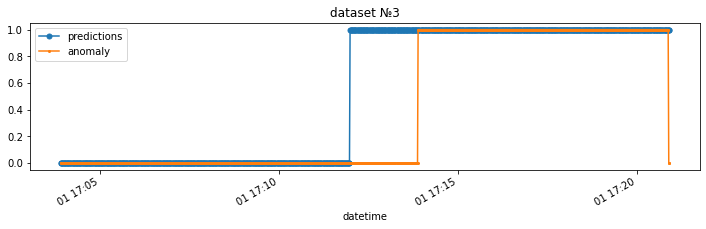

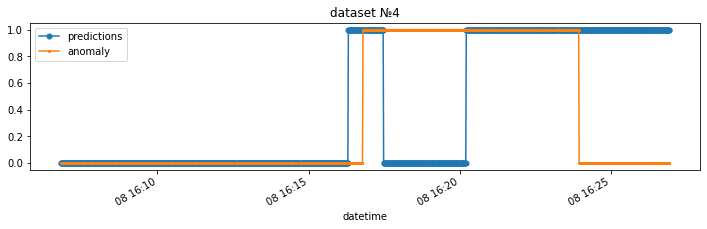

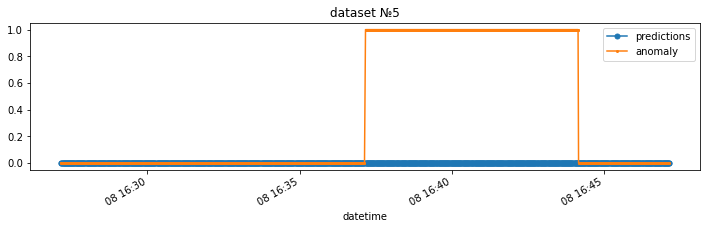

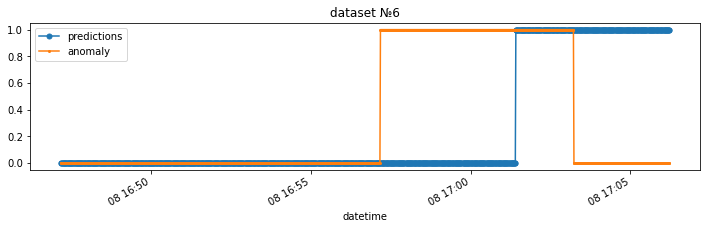

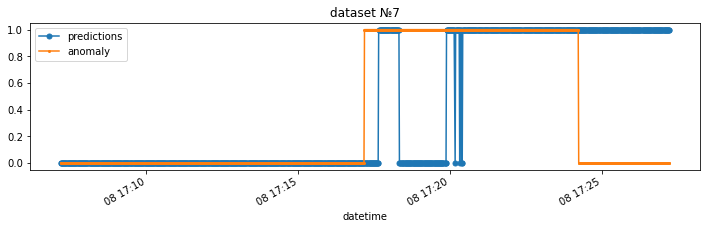

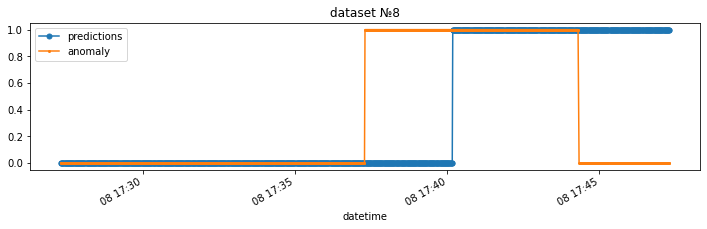

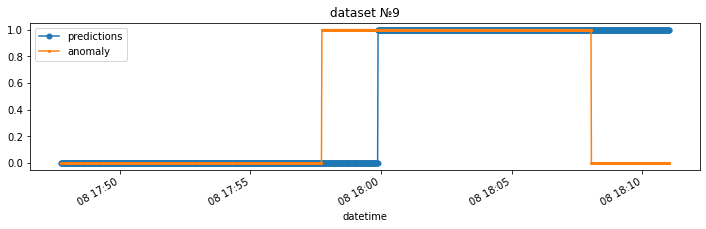

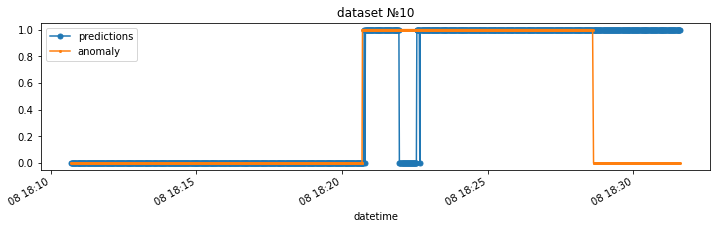

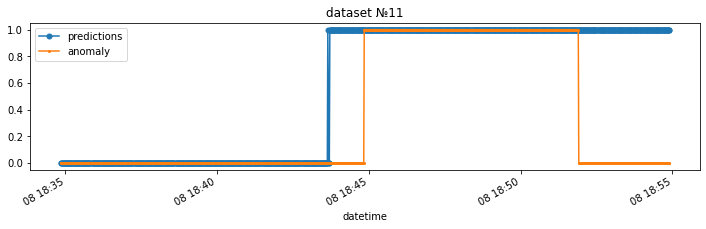

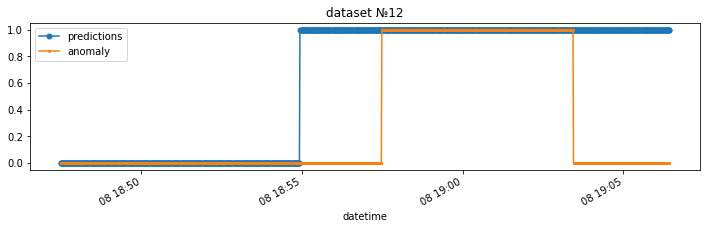

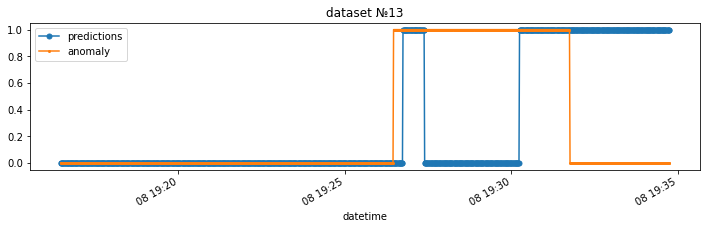

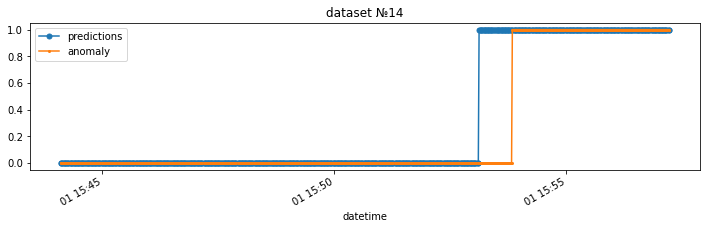

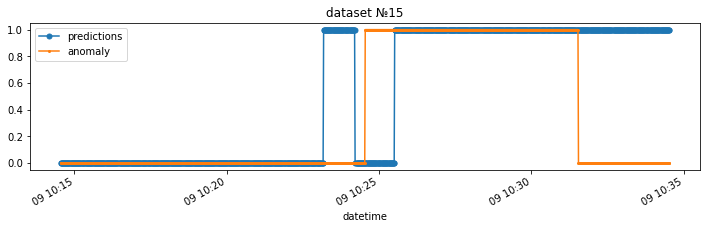

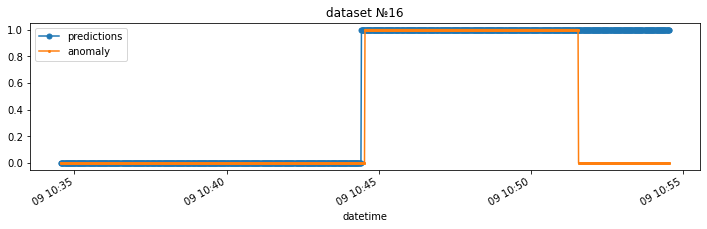

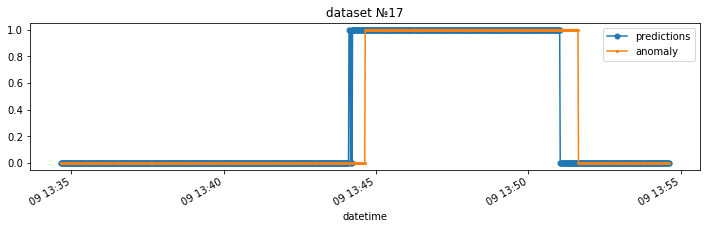

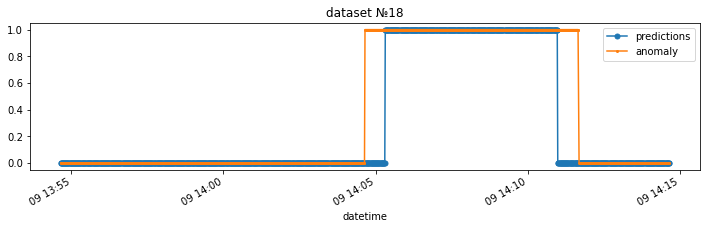

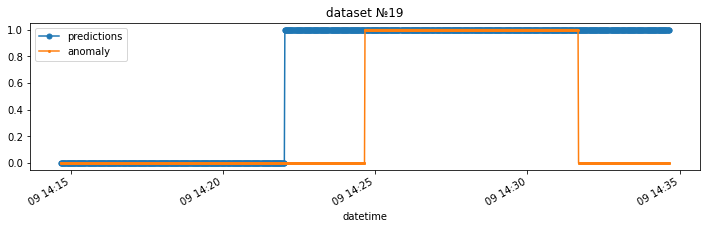

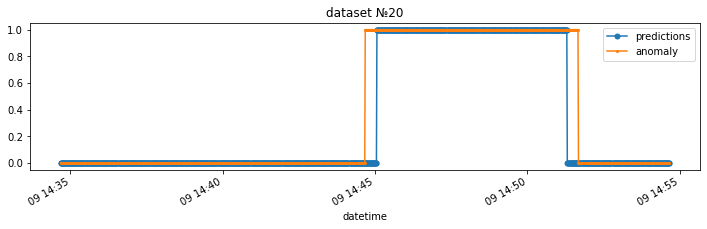

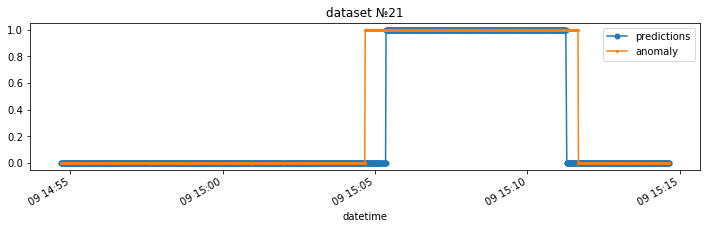

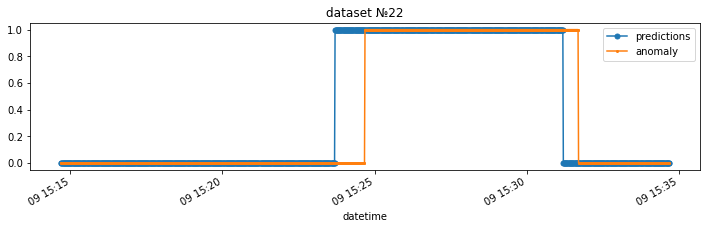

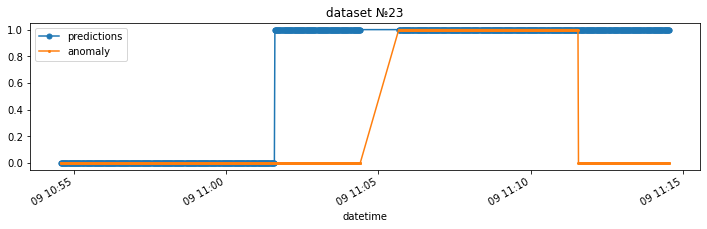

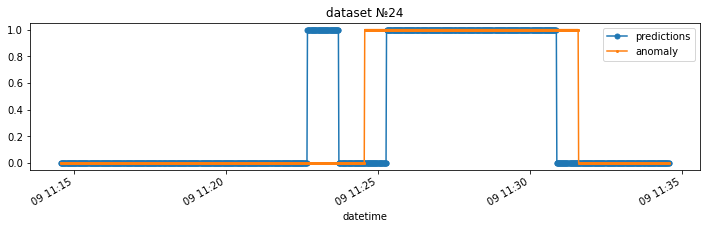

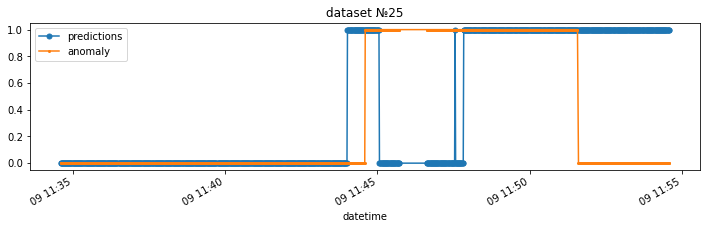

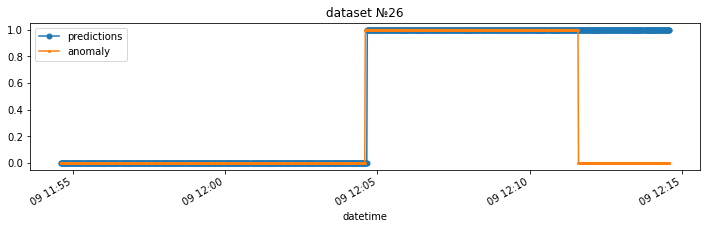

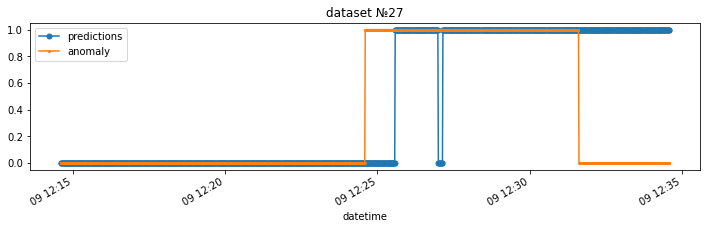

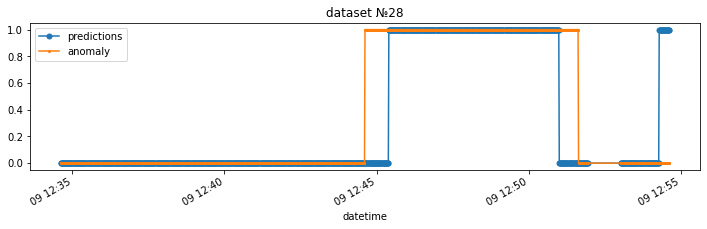

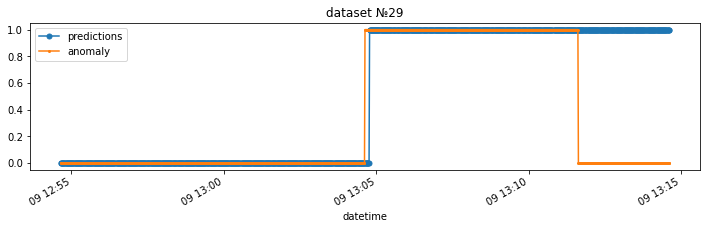

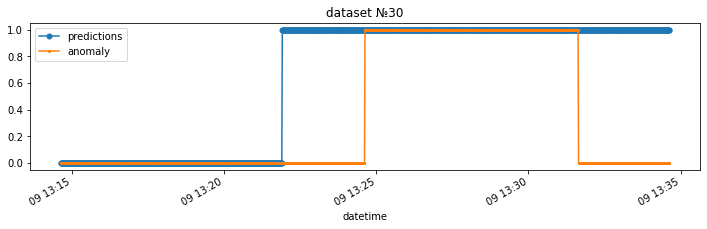

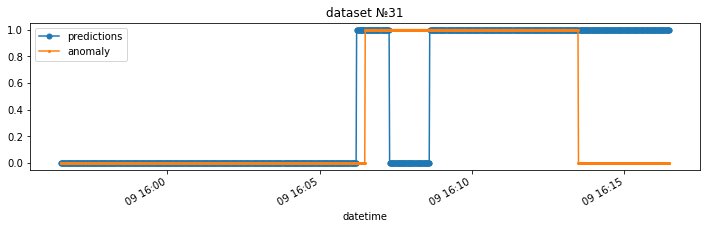

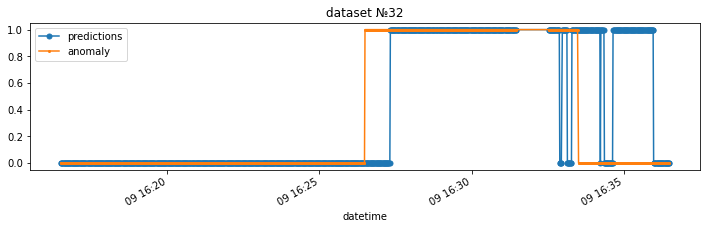

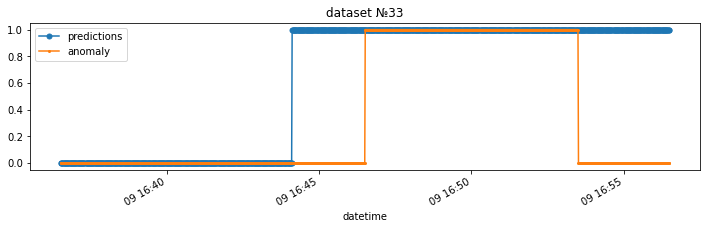

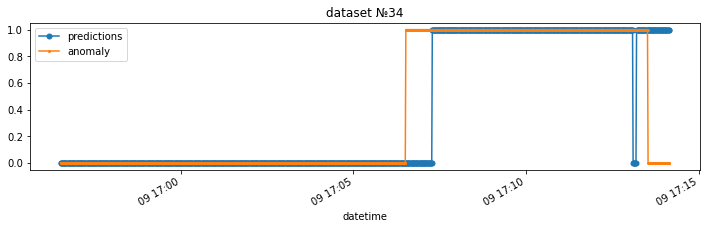

In [107]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

for i in range(len(predicted_outlier)):
    plt.figure(figsize=(12,3))
    plt.title(f'dataset №{i+1}')
    predicted_outlier[i].plot(label='predictions', marker='o', markersize=5)
    true_outlier[i].plot(marker='o', markersize=2)
    plt.legend()

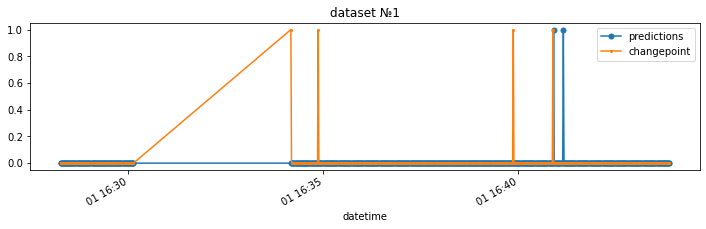

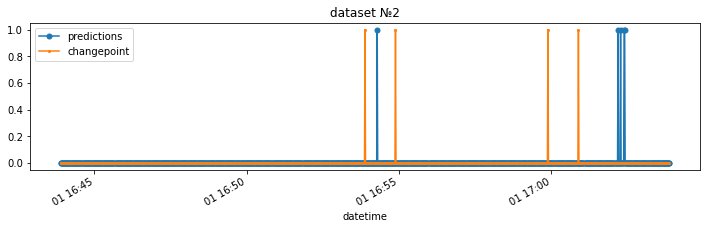

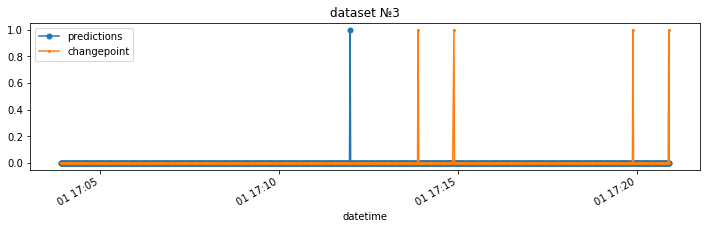

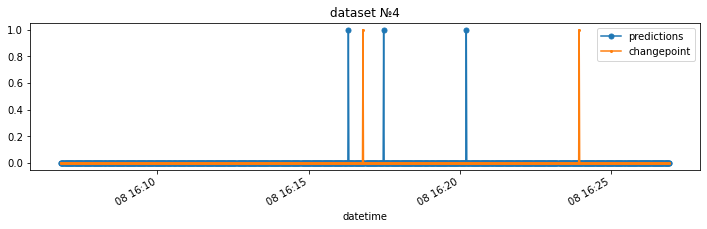

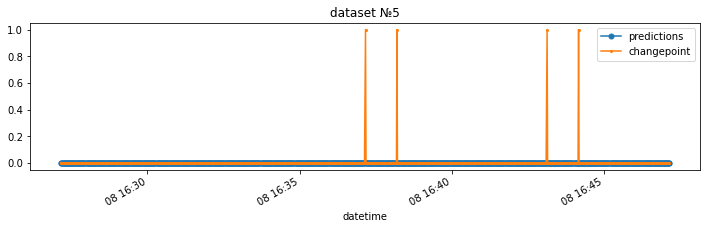

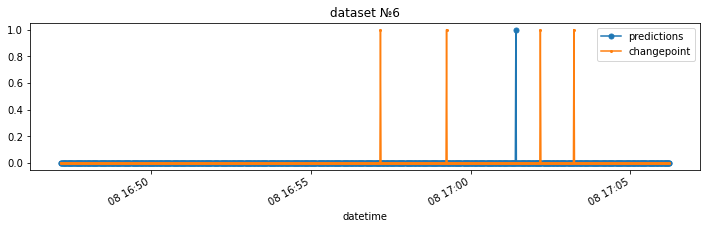

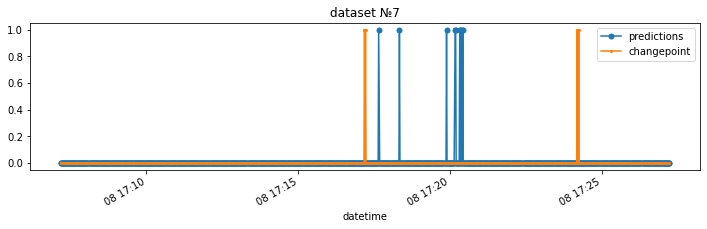

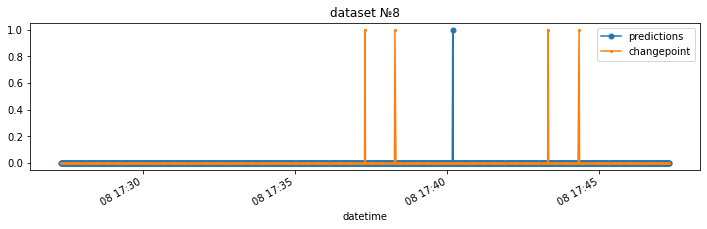

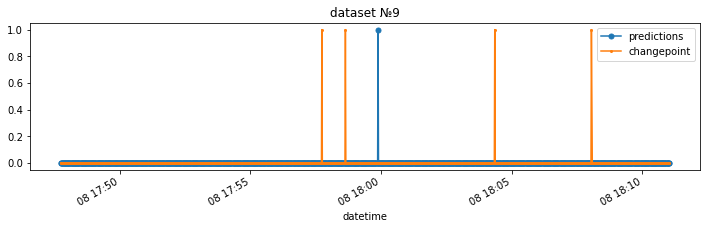

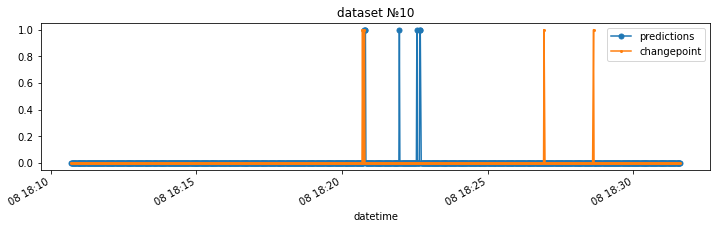

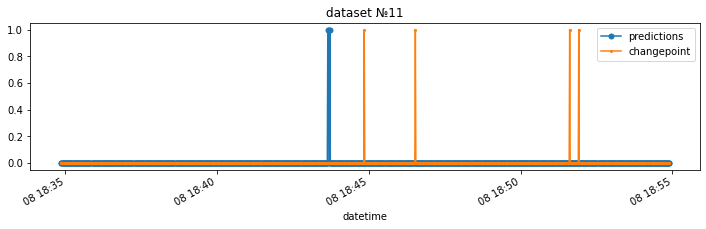

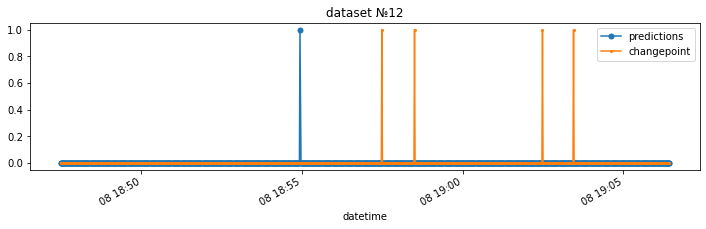

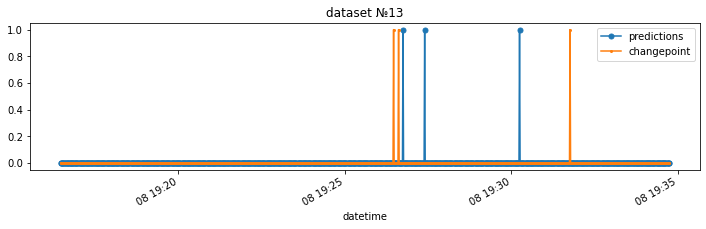

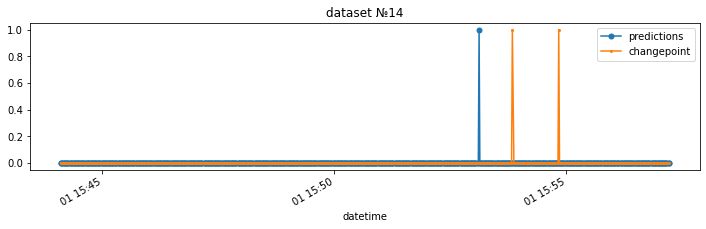

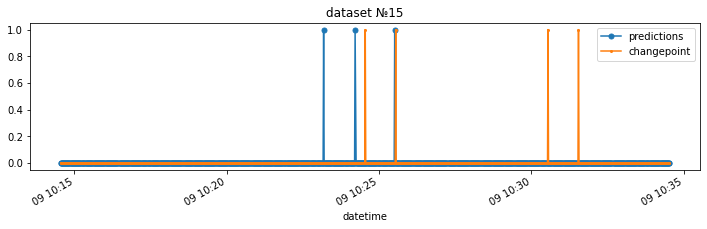

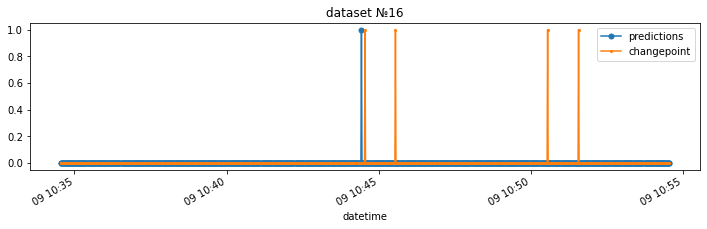

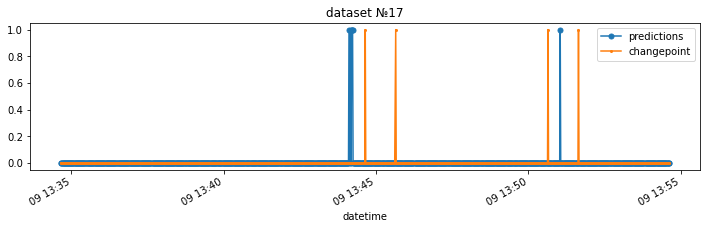

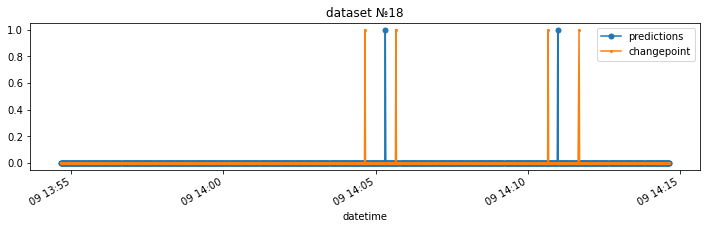

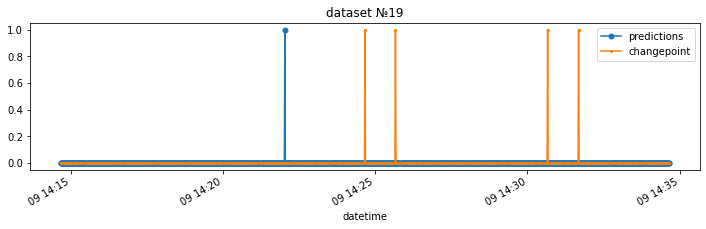

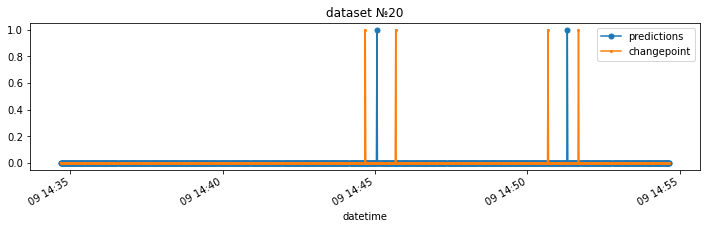

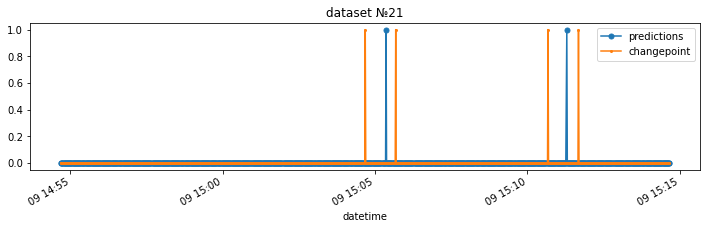

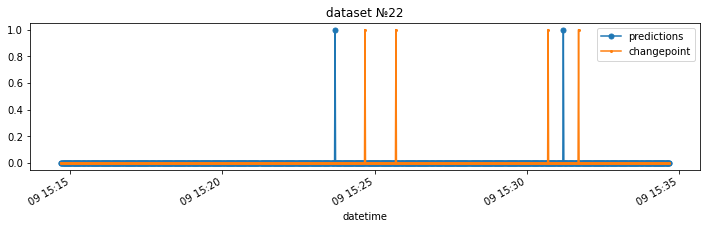

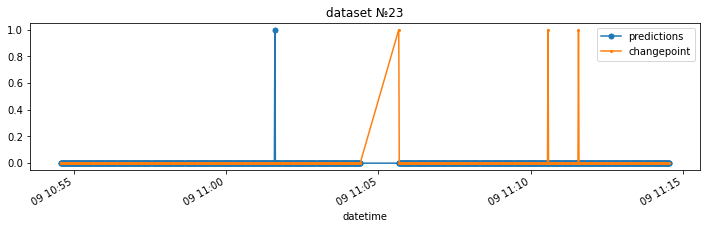

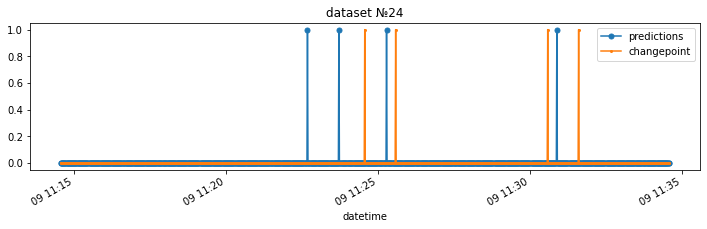

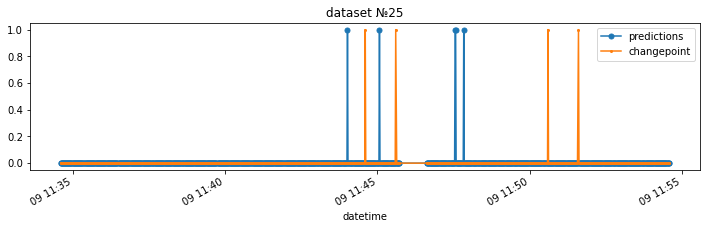

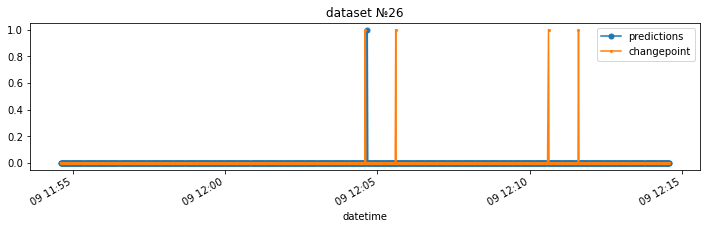

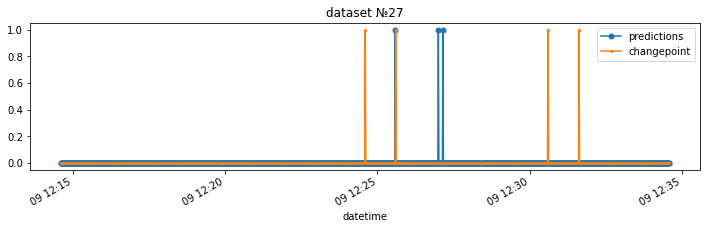

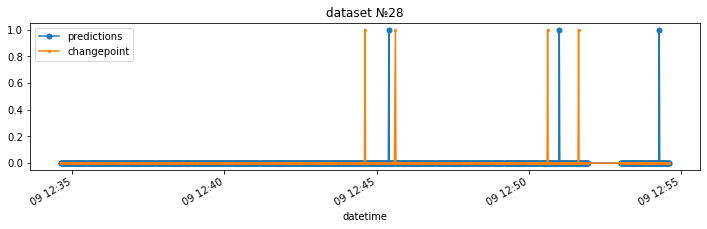

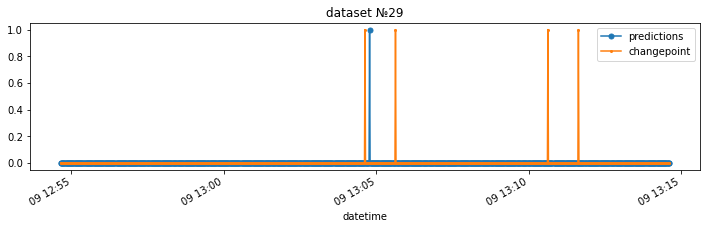

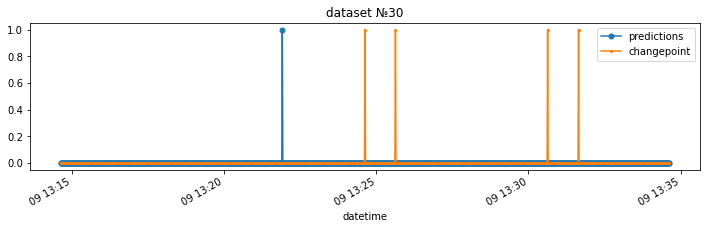

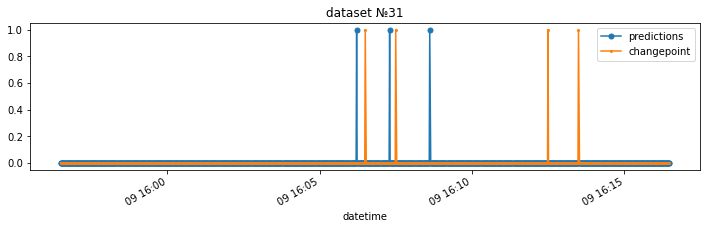

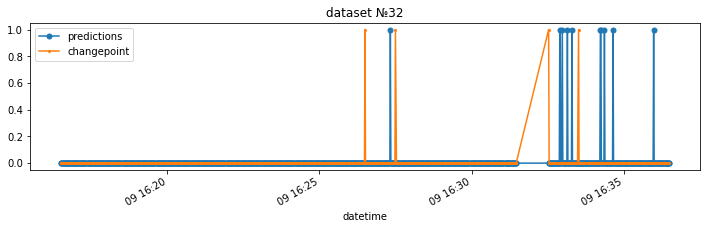

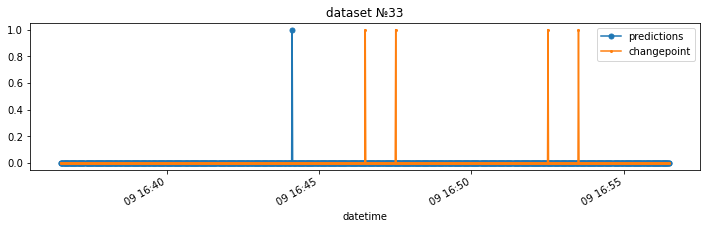

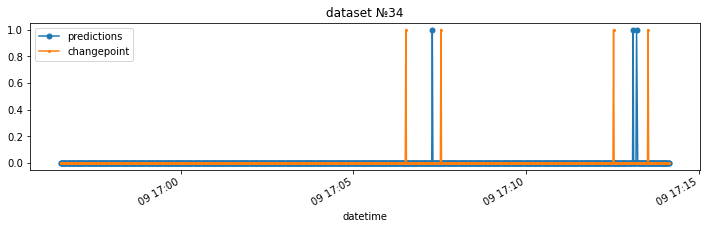

In [108]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

for i in range(len(predicted_cp)):
    plt.figure(figsize=(12,3))
    plt.title(f'dataset №{i+1}')
    predicted_cp[i].plot(label='predictions', marker='o', markersize=5)
    true_cp[i].plot(marker='o', markersize=2)
    plt.legend()

## Metrics calculation

In [109]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 20.82 %
Missing Alarm Rate 20.08 %
F1 metric 0.73


In [110]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:17.111111111
A number of missed CPs = 112


In [111]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Standart  -  12.71
LowFP  -  11.04
LowFN  -  13.6
